In [1]:
import os
import sys
import random
import math
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

from tqdm import tqdm
import skimage
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
from scipy.ndimage import zoom

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D, Conv2DTranspose, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.autograd import Variable


from tensorflow.python.client import device_lib

In [2]:
def get_mask_data():

    x_train_path = "dataset/Infection/mask_infection.npy"
    x_val_path = "dataset/Infection/mask_infection_val.npy"
    x_test_path = "dataset/Infection/mask_infection_test.npy"
    y_train_path = "dataset/Infection/y_train3.npy"
    y_val_path = "dataset/Infection/y_val3.npy"
    y_test_path = "dataset/Infection/y_test3.npy"
    
    x_train = np.load(x_train_path)
    x_val = np.load(x_val_path)
    x_test = np.load(x_test_path)
    y_train = np.load(y_train_path)
    y_val = np.load(y_val_path)
    y_test = np.load(y_test_path)

    print(x_train.shape, y_train.shape)
    print(x_val.shape, y_val.shape)
    print(x_test.shape, y_test.shape)
    
        
    return x_train, x_val, x_test, y_train, y_val, y_test


In [3]:
def VGG16_Unet(x_train, y_train, x_val, y_val) :
  
    inputs = Input(shape=(256, 256, 1))

    #down sampling 
    filters = 16       #feature map 수
    kernel_size = 3    # kernel size
    copy_layers = []   # Encoder에 있는 Activation map을 저장하는 리스트
    net = inputs
  
    #Encoder1
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #첫번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder2 
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #두번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder3
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #세번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder4
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #네번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #Encoder5
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #다섯번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #128
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    
    #Decoder : upsampling
    j = len(copy_layers) - 1
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #다섯번째 Activation map 
    
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    j = j -1 

    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #네번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #세번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #두번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #첫번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    outputs = Conv2D(2, 1, activation='sigmoid') (net)




    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['acc', tf.keras.metrics.MeanIoU(num_classes=3)])

    model.summary()
    
    
    

    return model

In [4]:
def Unet(x_train, y_train, x_val, y_val) :
    
    inputs = Input(shape=(256, 256, 1))
    
    f = 16
    layers = []
    net = inputs
  
    for i in range(0, 6):
        net = Conv2D(f, 3, activation='relu', padding='same') (net)
        net = Conv2D(f, 3, activation='relu', padding='same') (net)
        layers.append(net)
        net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
        f = f*2
        #512
    ff2 = 256
  
    #bottleneck 
    j = len(layers) - 1
    net = Conv2D(f, 3, activation='relu', padding='same') (net)
    net = Conv2D(f, 3, activation='relu', padding='same') (net)
    net = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, layers[j]])
    j = j -1 
  
    #upsampling 
    for i in range(0, 5):
        ff2 = ff2//2
        f = f // 2 
        net = Conv2D(f, 3, activation='relu', padding='same') (net)
        net = Conv2D(f, 3, activation='relu', padding='same') (net)
        print(net.shape)
        net = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (net)
        print(net.shape)
        net = Concatenate(axis=3)([net, layers[j]])
        j = j -1 
    
  
    #classification 
    net = Conv2D(f, 3, activation='relu', padding='same') (net)
    net = Conv2D(f, 3, activation='relu', padding='same') (net)
    outputs = Conv2D(2, 1, activation='sigmoid') (net)


    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', 'mse', tf.keras.metrics.MeanIoU(num_classes=2)])
    model.summary()
    
    return model

In [5]:
def training(model,x_train, y_train, x_val, y_val) :
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, batch_size=16, 
                      callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)])
    fig, ax = plt.subplots(3, 2, figsize=(10, 7))
    plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

    ax[0, 0].set_title('loss')
    ax[0, 0].plot(history.history['loss'], 'r')
    ax[0, 1].set_title('acc')
    ax[0, 1].plot(history.history['acc'], 'b')

    ax[1, 0].set_title('val_loss')
    ax[1, 0].plot(history.history['val_loss'], 'r--')
    ax[1, 1].set_title('val_acc')
    ax[1, 1].plot(history.history['val_acc'], 'b--')
    
    ax[2,0].set_title('MeanIoU')
    ax[2,0].plot(history.history['mean_io_u'], 'r')
    ax[2,1].set_title('val_MeanIoU')
    ax[2,1].plot(history.history['val_mean_io_u'], 'r')

#     predic = model.predict(x_val)

#     fig, ax = plt.subplots(40, 4, figsize=(10, 100))
    
#     temp = np.empty((256, 256, 1), dtype=np.float32)

#     for i in range(40):
#         ax[i, 0].imshow(x_val[i].squeeze(), cmap='hot')
#         ax[i, 0].title.set_text(str(i))
#         ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
#         ax[i, 2].imshow(predic[i].squeeze(), cmap='gray')
        
        
#         temp = x_val[i]
#         pred_sum = predic[i][predic[i] > 0]
#         pred_mean = np.mean(pred_sum)
#         if(np.min(x_val[i]) >= 0) :
#             predic[i] = (predic[i]/ np.max(predic[i])) * 255
#             temp = cv2.add(temp, predic[i])
#         else :
#             predic[i] = (predic[i]/ np.max(predic[i])) * 2048
#             temp = cv2.add(temp, predic[i])
#         ax[i, 3].imshow(temp.squeeze(), cmap='Reds')
# #         temp = x_val[i]
# #         pred_sum = preds[i][preds[i] > 0]
# #         pred_mean = np.mean(pred_sum)
# #         if(np.min(temp) >= 0) :
# #             temp[preds[i] < pred_mean] = 0
# #         else :
# #             temp[preds[i] < pred_mean] = -2048
# #         ax[i, 3].imshow(temp.squeeze(), cmap='gray')


(2380, 256, 256, 1) (2380, 256, 256, 2)
(295, 256, 256, 1) (295, 256, 256, 2)
(298, 256, 256, 1) (298, 256, 256, 2)
(None, 8, 8, 512)
(None, 16, 16, 128)
(None, 16, 16, 256)
(None, 32, 32, 64)
(None, 32, 32, 128)
(None, 64, 64, 32)
(None, 64, 64, 64)
(None, 128, 128, 16)
(None, 128, 128, 32)
(None, 256, 256, 8)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0] 

Epoch 1/30
149/149 [==============================] - 102s 561ms/step - loss: 1.9909 - acc: 0.9852 - mse: 0.0330 - mean_io_u: 0.3028 - val_loss: 0.0427 - val_acc: 0.9852 - val_mse: 0.0118 - val_mean_io_u: 0.2500
Epoch 2/30
149/149 [==============================] - 74s 497ms/step - loss: 0.1239 - acc: 0.9865 - mse: 0.0111 - mean_io_u: 0.2772 - val_loss: 0.0436 - val_acc: 0.9858 - val_mse: 0.0118 - val_mean_io_u: 0.2500
Epoch 3/30
149/149 [==============================] - 74s 498ms/step - loss: 0.0439 - acc: 0.9878 - mse: 0.0099 - mean_io_u: 0.2612 - val_loss: 0.0460 - val_acc: 0.9798 - val_mse: 0.0138 - val_mean_io_u: 0.2510
Epoch 4/30
149/149 [==============================] - 74s 497ms/step - loss: 0.0350 - acc: 0.9880 - mse: 0.0096 - mean_io_u: 0.2551 - val_loss: 0.0325 - val_acc: 0.9879 - val_mse: 0.0093 - val_mean_io_u: 0.2547
Epoch 5/30
149/149 [==============================] - 74s 500ms/step - loss: 0.0310 - acc: 0.9895 - mse: 0.0083 - mean_io_u: 0.2557 - val_loss: 0.0273 - va

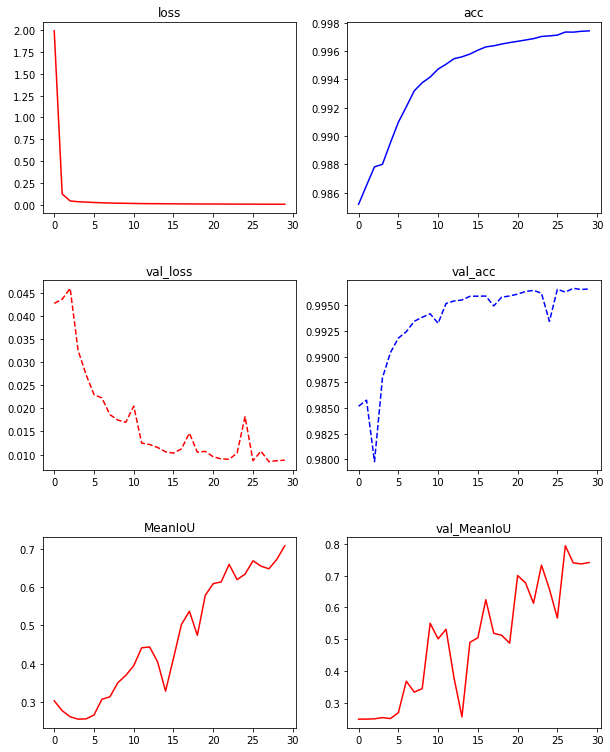

In [6]:
x_train,x_val,x_test, y_train, y_val, y_test = get_mask_data()
model = Unet(x_train, y_train, x_val, y_val)
history = training(model,x_train, y_train, x_val, y_val)

In [7]:
x_train,x_val,x_test, y_train, y_val, y_test = get_mask_data()
predic = model.predict(x_val)

(2380, 256, 256, 1) (2380, 256, 256, 2)
(295, 256, 256, 1) (295, 256, 256, 2)
(298, 256, 256, 1) (298, 256, 256, 2)


In [8]:
predict_0 = predic[...,0] #prediction (model output)

In [9]:
predict_0[predict_0 >= 0.5] = 1
predict_0[predict_0 < 0.5] = 0

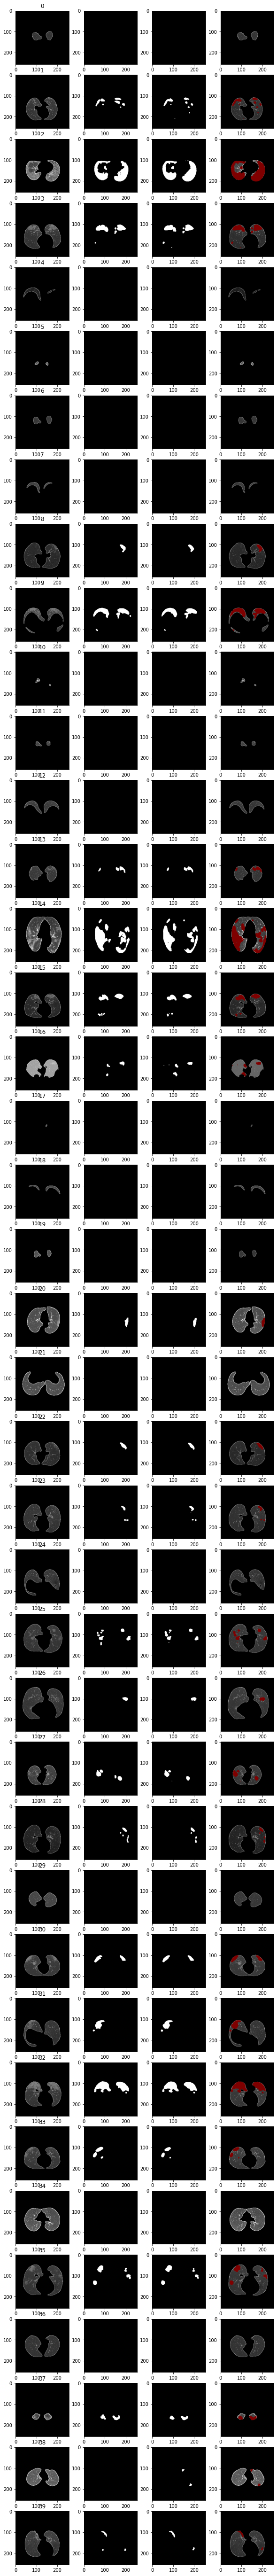

In [10]:
fig, ax = plt.subplots(40, 4, figsize=(10, 100))
    
temp = np.empty((256, 256, 3), dtype=np.float32)

y = y_val[...,0]
for i in range(40):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    ax[i, 0].title.set_text(str(i))
    ax[i, 1].imshow(y[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(predict_0[i].squeeze(), cmap='gray')
        
    point = np.where(predict_0[i] == 1)
    temp = resize(x_val[i], output_shape=(256,256,3), preserve_range = True)
    for j, x in enumerate(point[0]) :
        temp[x][point[1][j]] = (0.5,0,0)
    ax[i, 3].imshow(temp.squeeze())

(2380, 256, 256, 1) (2380, 256, 256, 2)
(295, 256, 256, 1) (295, 256, 256, 2)
(298, 256, 256, 1) (298, 256, 256, 2)


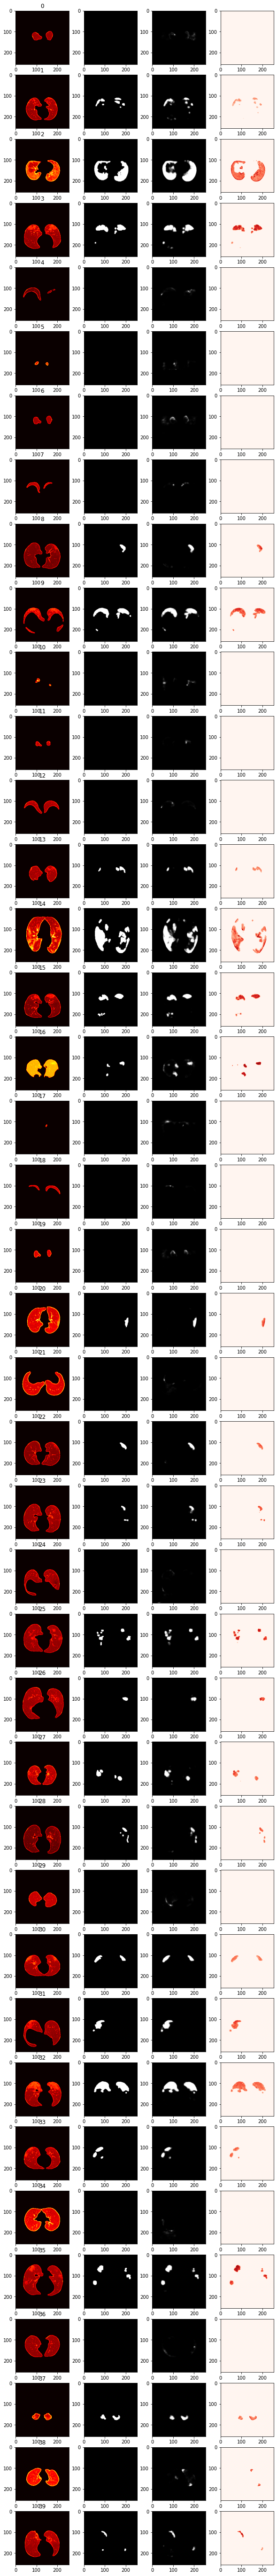

In [11]:
x_train,x_val,x_test, y_train, y_val, y_test = get_mask_data()
predic = model.predict(x_val)

fig, ax = plt.subplots(40, 4, figsize=(10, 100))
    
temp = np.empty((256, 256, 1), dtype=np.float32)

y = y_val[...,0]
predic_0 = predic[...,0]
for i in range(40):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='hot')
    ax[i, 0].title.set_text(str(i))
    ax[i, 1].imshow(y[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(predic_0[i].squeeze(), cmap='gray')
        
        
    temp = x_val[i]
    temp[predic_0[i] < 0.5] = 0
    ax[i, 3].imshow(temp.squeeze(), cmap='Reds')

In [15]:
y_val_com_0 = y_val[...,0] #image label 
predict_com_0 = predic[...,0] #prediction (model output)

IOU_SUM = 0.0
IOU_AVE = 0.0
Number_image =0

for n,_ in enumerate(y_val_com_0) :
    
    TP = 0
    NP = 0
    index = n
    
    y_label_image = y_val_com_0[index].copy()
    predict_image = predict_com_0[index].copy()

    #model output index번째 사진의 각 픽셀에 0.5보다 작으면 0 크면 1
    predict_image[predict_image < 0.5] = 0 
    predict_image[predict_image > 0.5] = 1

    #비교 해서 같으면 TP+1 아니면 NP+1
    for i in range(256) :
        for j in range(256) :
            if y_label_image[i][j] == 1 or predict_image[i][j] == 1:
                if y_label_image[i][j] == 1 and predict_image[i][j] == 1:
                    TP = TP + 1
                else :
                    NP = NP + 1
            
    if TP == 0 and NP == 0 : 
        TP = 1
    print('Number : ', n, 'TP :', TP,'NP : ', NP)
    print('IOU :', TP/ (TP + NP) , '\n')
    IOU_SUM = TP/ (TP + NP) + IOU_SUM
    Number_image = n
    
IOU_AVE = IOU_SUM / (Number_image + 1)
print("IOU_AVE : ", IOU_AVE)


Number :  0 TP : 1 NP :  0
IOU : 1.0 

Number :  1 TP : 982 NP :  450
IOU : 0.6857541899441341 

Number :  2 TP : 6399 NP :  852
IOU : 0.8824989656599089 

Number :  3 TP : 2241 NP :  381
IOU : 0.8546910755148741 

Number :  4 TP : 1 NP :  0
IOU : 1.0 

Number :  5 TP : 1 NP :  0
IOU : 1.0 

Number :  6 TP : 1 NP :  0
IOU : 1.0 

Number :  7 TP : 1 NP :  0
IOU : 1.0 

Number :  8 TP : 491 NP :  88
IOU : 0.8480138169257341 

Number :  9 TP : 2832 NP :  594
IOU : 0.8266199649737302 

Number :  10 TP : 1 NP :  0
IOU : 1.0 

Number :  11 TP : 1 NP :  0
IOU : 1.0 

Number :  12 TP : 1 NP :  0
IOU : 1.0 

Number :  13 TP : 681 NP :  129
IOU : 0.8407407407407408 

Number :  14 TP : 6325 NP :  2320
IOU : 0.7316367842683632 

Number :  15 TP : 1623 NP :  352
IOU : 0.8217721518987342 

Number :  16 TP : 448 NP :  393
IOU : 0.5326991676575505 

Number :  17 TP : 1 NP :  0
IOU : 1.0 

Number :  18 TP : 1 NP :  0
IOU : 1.0 

Number :  19 TP : 1 NP :  0
IOU : 1.0 

Number :  20 TP : 481 NP :  64
IOU

Number :  157 TP : 2250 NP :  1341
IOU : 0.6265664160401002 

Number :  158 TP : 2186 NP :  365
IOU : 0.8569188553508428 

Number :  159 TP : 1 NP :  0
IOU : 1.0 

Number :  160 TP : 1 NP :  0
IOU : 1.0 

Number :  161 TP : 489 NP :  112
IOU : 0.8136439267886856 

Number :  162 TP : 1 NP :  0
IOU : 1.0 

Number :  163 TP : 1018 NP :  218
IOU : 0.8236245954692557 

Number :  164 TP : 0 NP :  35
IOU : 0.0 

Number :  165 TP : 2386 NP :  837
IOU : 0.7403040645361465 

Number :  166 TP : 1587 NP :  349
IOU : 0.8197314049586777 

Number :  167 TP : 204 NP :  252
IOU : 0.4473684210526316 

Number :  168 TP : 497 NP :  171
IOU : 0.7440119760479041 

Number :  169 TP : 1 NP :  0
IOU : 1.0 

Number :  170 TP : 989 NP :  282
IOU : 0.7781274586939417 

Number :  171 TP : 1 NP :  0
IOU : 1.0 

Number :  172 TP : 1 NP :  0
IOU : 1.0 

Number :  173 TP : 1 NP :  0
IOU : 1.0 

Number :  174 TP : 1327 NP :  487
IOU : 0.7315325248070562 

Number :  175 TP : 164 NP :  282
IOU : 0.36771300448430494 

Num